In [1]:
import sys
import pandas as pd
import torch 
import os 

sys.path.append("../..")
# For retrieval

from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.docstore.document import Document
from sentence_transformers import CrossEncoder
from langchain.text_splitter import RecursiveCharacterTextSplitter

from financerag.tasks import FinQABench

/Users/emrekuru/Developer/FinanceRAG/.venv/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [2]:
import warnings

warnings.filterwarnings('ignore')

## Read Data

In [3]:
task = FinQABench()

A Hugging Face repository is provided. This will override the data_folder, prefix, and *_file arguments.


In [4]:
queries = task.queries
query_df = pd.DataFrame(queries.values(), index=queries.keys(), columns=["query"])

,query
q4aa0b116,What is the redemption price for the 0.875% 20...
q4aa0a48c,What is the maturity date of the 0.875% 2025 N...
q4aa0aeb4,What are the conditions under which the Compan...
q4aa05fa4,What is the Company's investment policy and st...
q4aa092f8,What is the purpose of the Company's internal ...
...,...
q4aa01fda,What risks are associated with the Company's i...
q4aa0a1d0,What percentage of outstanding shares must vot...
q4aa0a34c,What is the minimum percentage of shares requi...
q4aa05284,What was the approximate dollar value of share...


In [5]:
documents = task.corpus
documents_df = pd.DataFrame(documents.values(), index=documents.keys(), columns=["title", "text"])

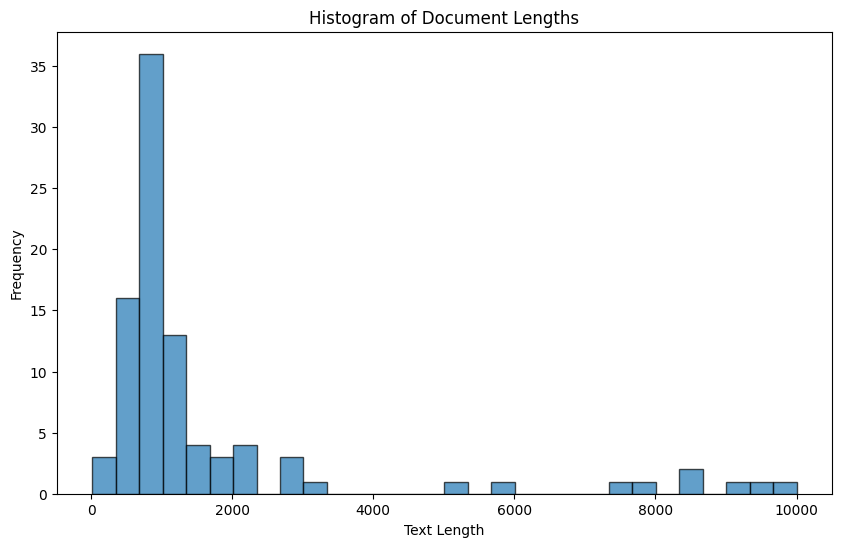

In [6]:
import matplotlib.pyplot as plt

# Calculate the length of each text
documents_df['text_length'] = documents_df['text'].apply(len)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(documents_df['text_length'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Histogram of Document Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

## Initiliaze Database

In [7]:
embedder = HuggingFaceEmbeddings(model_name="msmarco-distilbert-base-v4")

persist_directory = ".chroma"

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=800,  # Define chunk size
    chunk_overlap=100  # Define overlap to maintain context between chunks
)

docs = []
for id, text in documents_df.text.items():
    # Split the document into chunks
    chunks = text_splitter.split_text(text)
    
    # Create a Document object for each chunk but store the parent document ID in the metadata
    for i, chunk in enumerate(chunks):
        doc = Document(page_content=chunk, metadata={"id": str(id), "chunk_index": i})
        docs.append(doc)

if os.path.exists(persist_directory):
    # Load the existing ChromaDB
    chroma_db = Chroma(persist_directory=persist_directory, embedding_function=embedder)
    print("Loaded existing ChromaDB from .chroma")
else:
    # Create ChromaDB and store the documents
    chroma_db = Chroma.from_documents(
        documents=docs,
        embedding=embedder,
        persist_directory=persist_directory,  
    )
    print("Created new ChromaDB and saved to .chroma")


Created new ChromaDB and saved to .chroma


## Retrieve

In [8]:
retriever = chroma_db.as_retriever(search_kwargs={"k": 100})

In [9]:
retrieved_df = pd.DataFrame([[{} ] for _ in query_df.index], index=query_df.index, columns=["Documents"])

In [10]:
for idx, query in query_df["query"].items():

    retrieved = retriever.invoke(query)

    retrieved = {
        str(doc.metadata["id"]):  1
        for doc in retrieved
    }
    retrieved_df.loc[idx]["Documents"] = retrieved

retrieved_results = retrieved_df["Documents"].to_dict()

## Re-Rank

In [11]:
cross_encoder = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")

def sigmoid(x):
    return 1 / (1 + torch.exp(-torch.tensor(x)))

for idx, query in query_df["query"].items():
    for doc_id in retrieved_results[idx]:

        raw_score = cross_encoder.predict((query, documents_df.loc[doc_id].text))
        normalized_score = sigmoid(raw_score).item()

        retrieved_results[idx][doc_id] = normalized_score
    
    retrieved_results[idx] = dict(sorted(retrieved_results[idx].items(), key=lambda item: item[1], reverse=True))

In [12]:
retrieved_results["q4aa1b5ac"]

{'d4aa1b854': 0.9992239475250244,
 'd4aa0d92a': 0.9899457097053528,
 'd4aa0dc22': 0.8248130679130554,
 'd4aa0d740': 0.05338200926780701,
 'd4aa079c6': 0.0024027652107179165,
 'd4aa11cbe': 0.00020592492364812642,
 'd4aa124fc': 0.000175886059878394,
 'd4aa04cc6': 0.00014075955550651997,
 'd4aa0abd0': 0.0001075760301318951,
 'd4aa18744': 0.00010059699707198888,
 'd4aa1530a': 9.677391062723473e-05,
 'd4aa05d24': 6.285328709054738e-05,
 'd4aa0839e': 6.129781104391441e-05,
 'd4aa08ad8': 5.668839003192261e-05,
 'd4aa051b2': 5.503996726474725e-05,
 'd4aa00b94': 5.170282020117156e-05,
 'd4aa110e8': 4.806463039130904e-05,
 'd4aa1afee': 4.3704643758246675e-05,
 'd4aa05ebe': 4.278898995835334e-05,
 'd4aa075a2': 4.270183853805065e-05,
 'd4aa005d6': 3.886871490976773e-05,
 'd4aa113f4': 3.731861215783283e-05,
 'd4aa18e92': 3.602101787691936e-05,
 'd4aa099d8': 3.567999374354258e-05,
 'd4aa04834': 3.423200541874394e-05,
 'd4aa05be4': 3.2638585253152996e-05,
 'd4aa00978': 3.263472535763867e-05,
 'd4aa0a

## Evaluate

In [13]:
qrels = pd.read_csv('../../data/resources/finq_qrels.tsv', sep='\t')

In [14]:
qrels_dict = {}
for index, row in qrels.iterrows():
    key = row['query_id']
    if key not in qrels_dict:
        qrels_dict[key] = {}
    qrels_dict[key][row['corpus_id']] = row['score']

{'q4a9ffea6': {'d4a9fff3c': 1},
 'q4aa001f8': {'d4aa00266': 1},
 'q4aa013c8': {'d4aa01440': 1},
 'q4aa01b02': {'d4aa01b7a': 1},
 'q4aa01e4a': {'d4aa01ecc': 1},
 'q4aa049ba': {'d4aa01440': 1},
 'q4aa04c12': {'d4aa04cc6': 1},
 'q4aa05284': {'d4aa05306': 1},
 'q4aa055e0': {'d4aa05662': 1},
 'q4aa05fa4': {'d4aa06030': 1},
 'q4aa061ca': {'d4aa06274': 1},
 'q4aa06710': {'d4aa067ba': 1},
 'q4aa06af8': {'d4aa06b84': 1},
 'q4aa0767e': {'d4aa07714': 1},
 'q4aa078fe': {'d4aa079c6': 1},
 'q4aa07c0a': {'d4aa06b84': 1},
 'q4aa07f02': {'d4aa04e60': 1},
 'q4aa0818c': {'d4aa0822c': 1},
 'q4aa0843e': {'d4aa084de': 1},
 'q4aa089e8': {'d4aa08ad8': 1},
 'q4aa0a48c': {'d4aa0a52c': 1},
 'q4aa0a928': {'d4aa0a9e6': 1},
 'q4aa0aafe': {'d4aa0abd0': 1},
 'q4aa0b116': {'d4aa0b1f2': 1},
 'q4aa0b634': {'d4aa0b6fc': 1},
 'q4aa0d862': {'d4aa0d92a': 1},
 'q4aa0dd62': {'d4aa10314': 1},
 'q4aa11264': {'d4aa113f4': 1},
 'q4aa175b0': {'d4aa18744': 1},
 'q4aa1b5ac': {'d4aa1b854': 1}}

In [17]:
k_values = [1, 3, 10]
results = task.evaluate(qrels=qrels_dict, results=retrieved_results, k_values=k_values)

In [18]:
metrics_df = pd.DataFrame(index=k_values, columns=["MAP", "NDCG", "P@K", "R@K"])

metrics_df["MAP"] = [results[1][f"MAP@{k}"] for k in k_values]
metrics_df["NDCG"] = [results[0][f"NDCG@{k}"] for k in k_values]
metrics_df["P@K"] = [results[3][f"P@{k}"] for k in k_values]
metrics_df["R@K"] = [results[2][f"Recall@{k}"] for k in k_values]

metrics_df

,MAP,NDCG,P@K,R@K
1,0.80000,0.80000,0.80000,0.80000
3,0.82778,0.83770,0.28889,0.86667
10,0.84694,0.87546,0.09667,0.96667
